In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import statsmodels.api as sm
import pandas as pd
import os
import time
from regression import *

saved as Regression/timeseries_2024-08-25_12-09-50.pdf
saved as Regression/timeseries_2024-08-25_12-09-51.csv


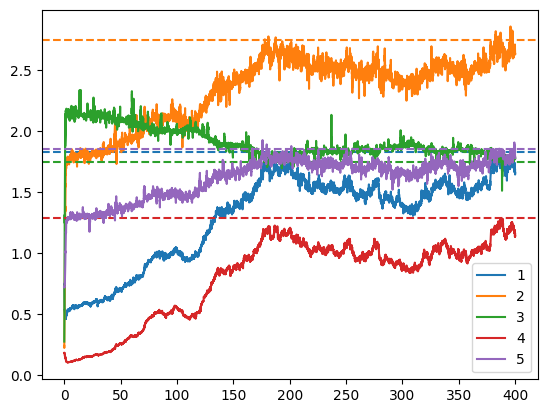

In [2]:
gsLV = Linearized_stochastic_dynamics(num_species= 5)
eq = gsLV.sample_equilibrium()
M = gsLV.Lstable_matrix()
initial = gsLV.sample_initial(vmin = 0.1, vmax = 1)

data = gsLV.simulate(day_max= 400, sampling_interval= 0.01, noise= 5)
medians = [float(np.median(data[s, :])) for s in range(gsLV.num_species)]
means = [float(np.mean(data[s, :])) for s in range(gsLV.num_species)]

Fisher logarithm
----------------------
RMSE -1.1186962802530325, Frobenious 0.18032411541432009, cosine 0.9889038639103852, jaccard 2.8518111426103796
derivative 
----------------------
RMSE -1.0123254179886827, Frobenious 0.16317805711211597, cosine 0.9930526633434152, jaccard 2.650580000649889


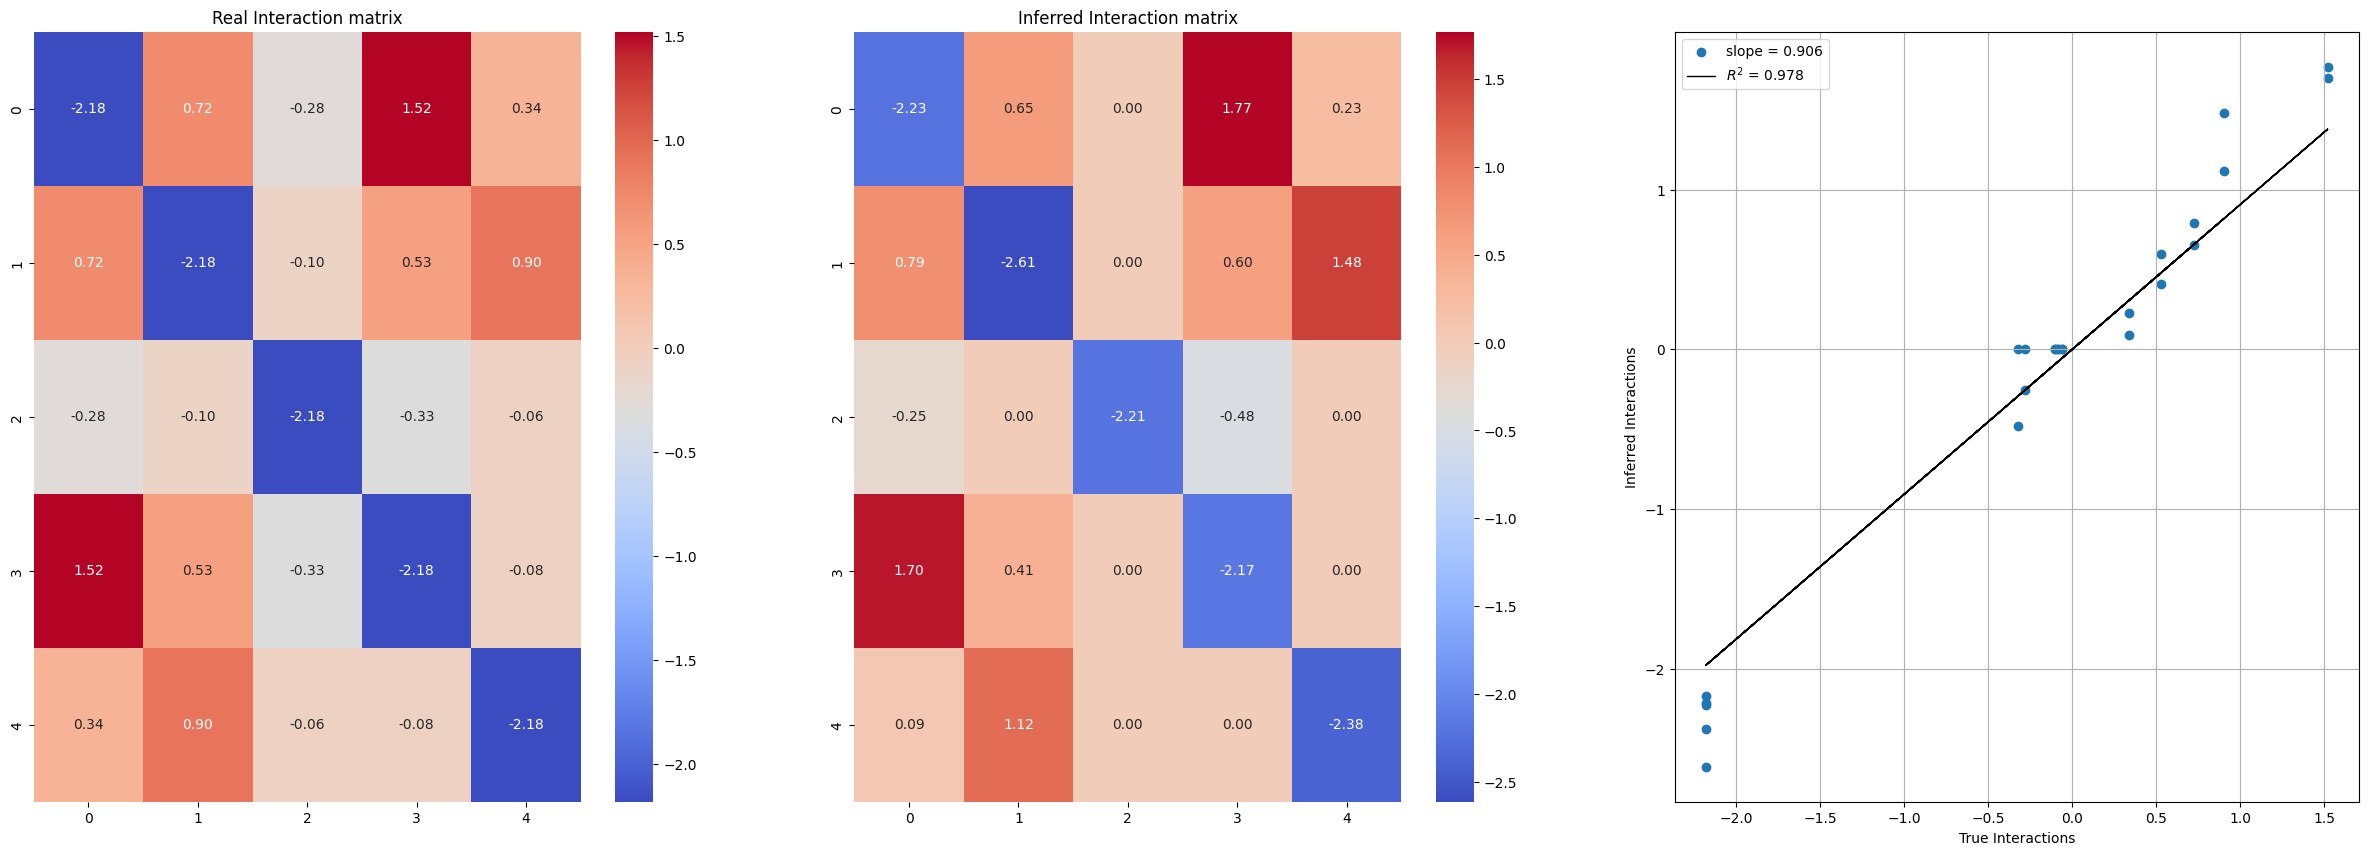

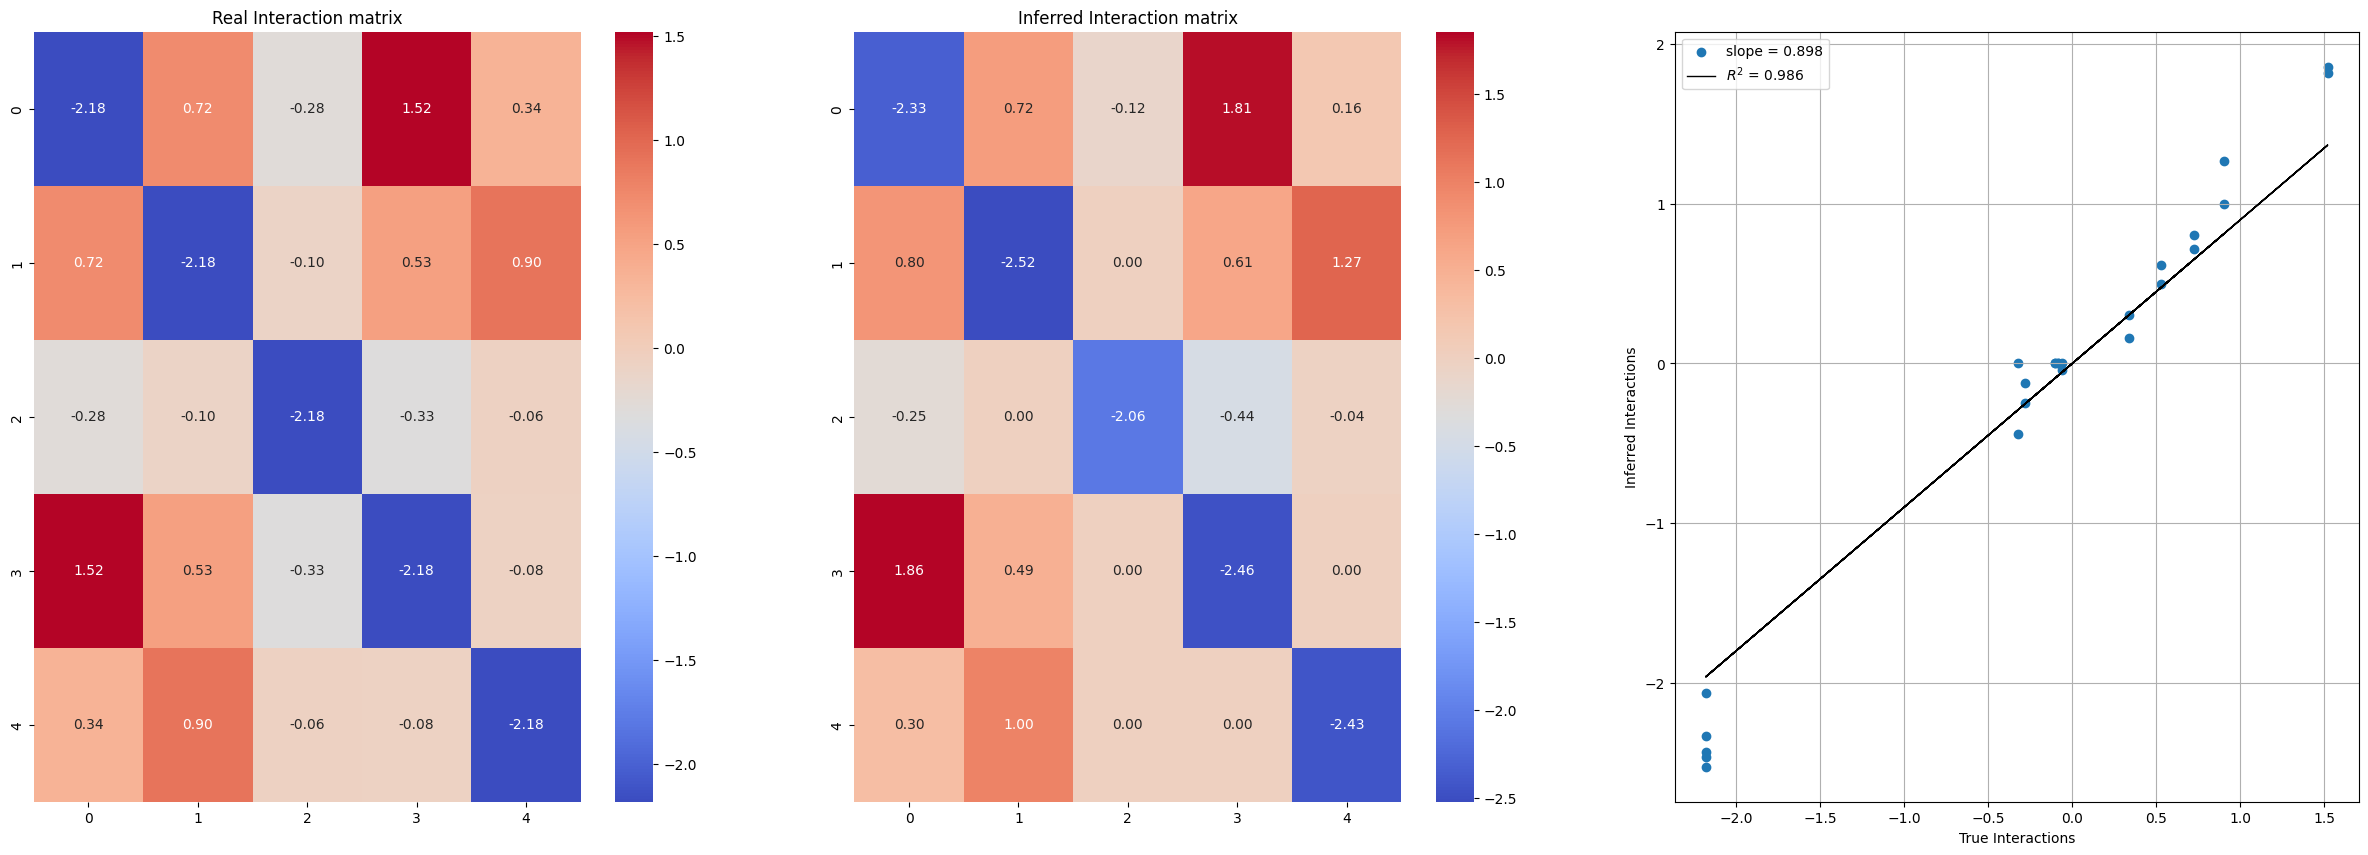

In [6]:
thr = 0.01
sampling = 0.01

regression_fisher = Regression(data[:, int(150//sampling):], transpose=True, method='logarithm', sampling= sampling,threshold= thr, bagging_iterations= 10, verbose = False)
M_fisher = regression_fisher.LIMITS()

regression_derivative = Regression(data[:, int(150//sampling):], transpose=True, method='derivative', sampling= sampling,threshold= thr, bagging_iterations= 10, verbose = False)
M_derivative = regression_derivative.LIMITS()

#rescaling
M_fisher /= sampling

num_rows = len(M_derivative)
num_cols = len(M_derivative[0])
assert len(medians) == num_rows, "Size of medians array does not match the number of rows in M_derivative."
for i in range(num_rows):
    for j in range(num_cols):
        if medians[i] != 0:  # Avoid division by zero
            M_derivative[i][j] /= medians[i]
        else:
            print(f"Warning: Division by zero for median value at index {i}.")


mc = Matrix_Comparison()

r2, slope = mc.compare_matrices(M, M_fisher, normalize= False, plot= True, savefig=False)
time.sleep(1)
r2, slope = mc.compare_matrices(M, M_derivative, normalize= False, plot= True, savefig=False) 


print("Fisher logarithm")
print("----------------------")
print(f"RMSE {mc.root_mean_squared_error(M, M_fisher)}, Frobenious {mc.relative_error_frobenius_norm(M, M_fisher)}, cosine {mc.cosine_similarity_matrix(M, M_fisher)}, jaccard {mc.jaccard_index_weighted(M, M_fisher)}")

print("derivative ")
print("----------------------")
print(f"RMSE {mc.root_mean_squared_error(M, M_derivative)}, Frobenious {mc.relative_error_frobenius_norm(M, M_derivative)}, cosine {mc.cosine_similarity_matrix(M, M_derivative)}, jaccard {mc.jaccard_index_weighted(M, M_derivative)}")


# Testing performance on simulated LV data

In [16]:
sampling = 0.1
sparsity = 0.7
d_max = 200
sigma = 3
n_min = 10
n_max = 10 #max number of species (if n is the number of species, then on average, n/2 species survive)
tmin = int(10/sampling) #to delete transient phase

thr = 0.1
bag = 100

repeat = 5

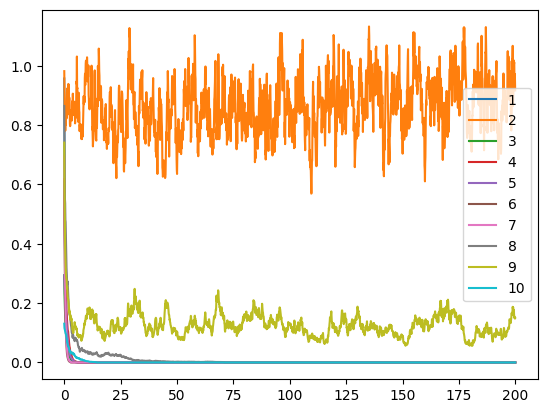

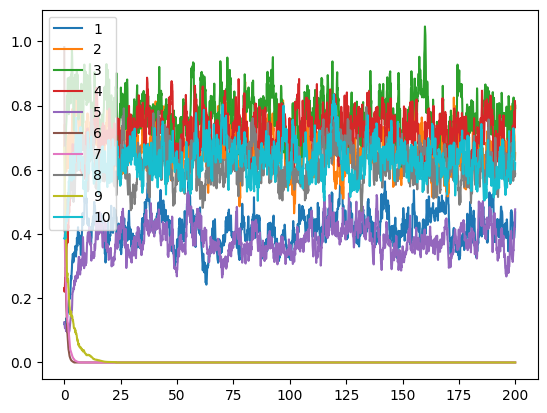

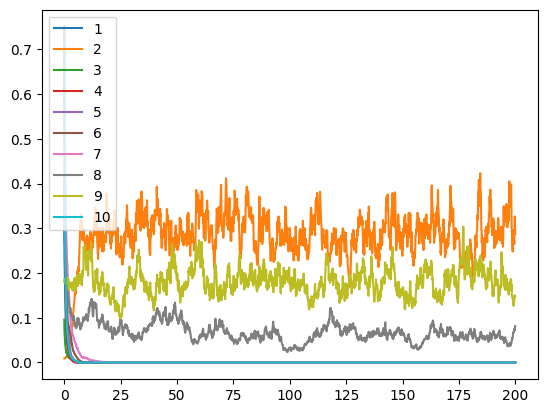

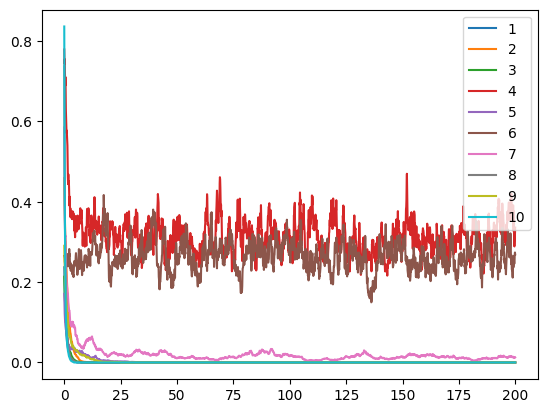

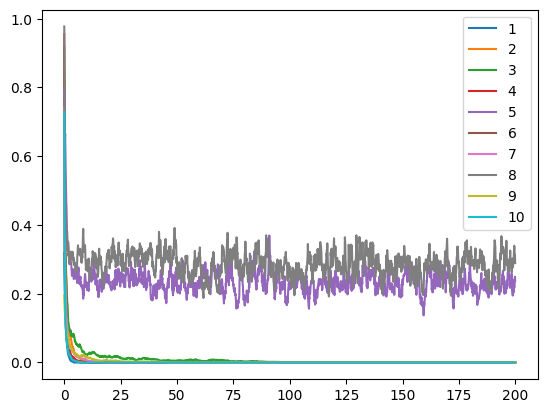

In [17]:
data_list = []
M_list = []
M_fisher_list = []
M_derivative_list = []

for n in range(n_min, n_max+1):
    for _ in range(repeat):
        # data simulation
        lv = LV(num_species= n, noise= sigma, sparsity = sparsity)
        data_list = []
        data = lv.simulate(day_max= d_max, sampling_interval= sampling)
        medians = np.median(data[:, :], axis = 1)
        extinct = []
        for s in range(len(data)):
            if not medians[s]> 0.01:
                extinct.append(s)
        data = np.delete(data, extinct, axis= 0)
        data_list.append(data)
        medians = np.delete(medians, extinct)
        extinct_species = [e + 1 for e in extinct]
        survived = list(set(range(lv.num_species)) - set(extinct))
        M = lv.M[np.ix_(survived, survived)]
        M_list.append(M)

        # data fitting
        regression_fisher = Regression(data[:, tmin:], transpose=True, method='logarithm', sampling= sampling,threshold= thr, bagging_iterations= 10, verbose = False)
        M_fisher = regression_fisher.LIMITS()

        regression_derivative = Regression(data[:, tmin:], transpose=True, method='derivative', sampling= sampling,threshold= thr, bagging_iterations= 10, verbose = False)
        M_derivative = regression_derivative.LIMITS()

        # rescaling
        M_fisher /= sampling

        num_rows = M_derivative.shape[0]
        num_cols = M_derivative.shape[1]
        assert len(medians) == num_rows, "Size of medians array does not match the number of rows in M_derivative."
        for i in range(num_rows):
            for j in range(num_cols):
                if medians[i] != 0:  # Avoid division by zero
                    M_derivative[i][j] /= medians[i]
                else:
                    print(f"Warning: Division by zero for median value at index {i}.")

        M_fisher_list.append(M_fisher)
        M_derivative_list.append(M_derivative)

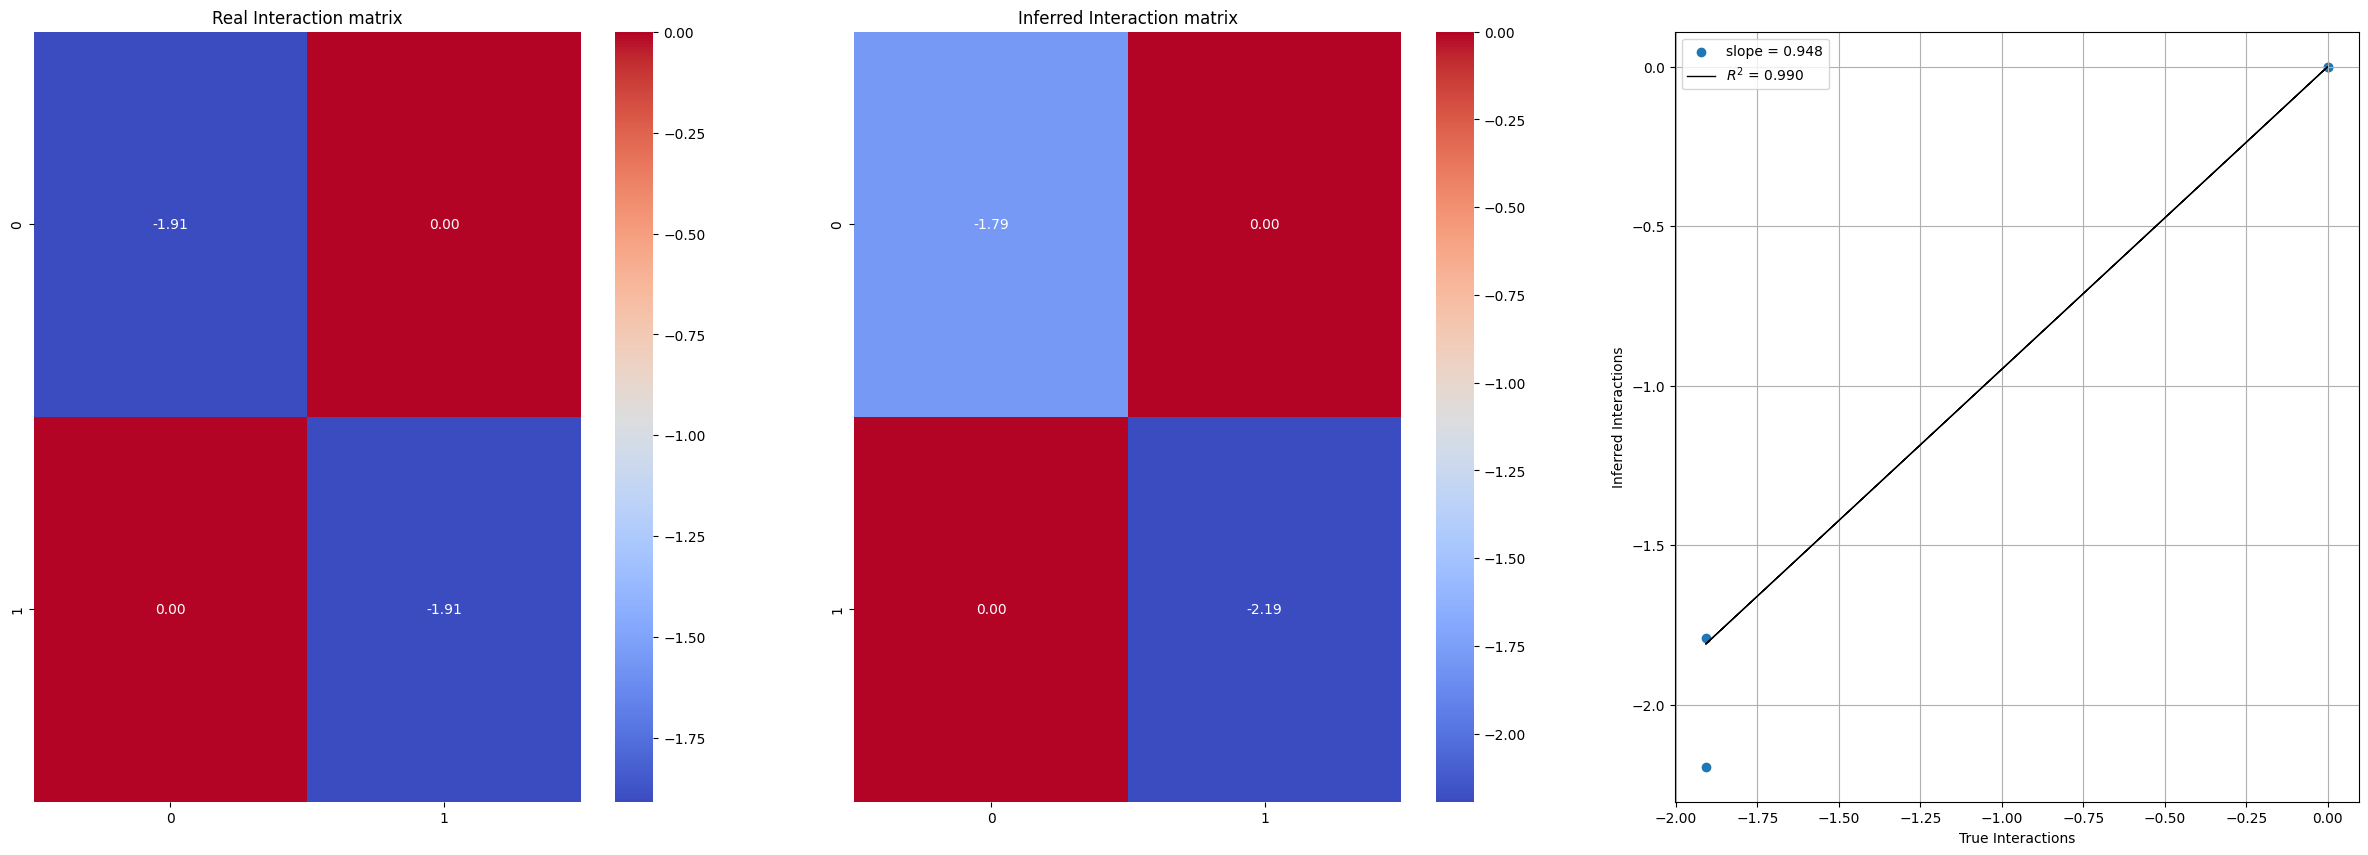

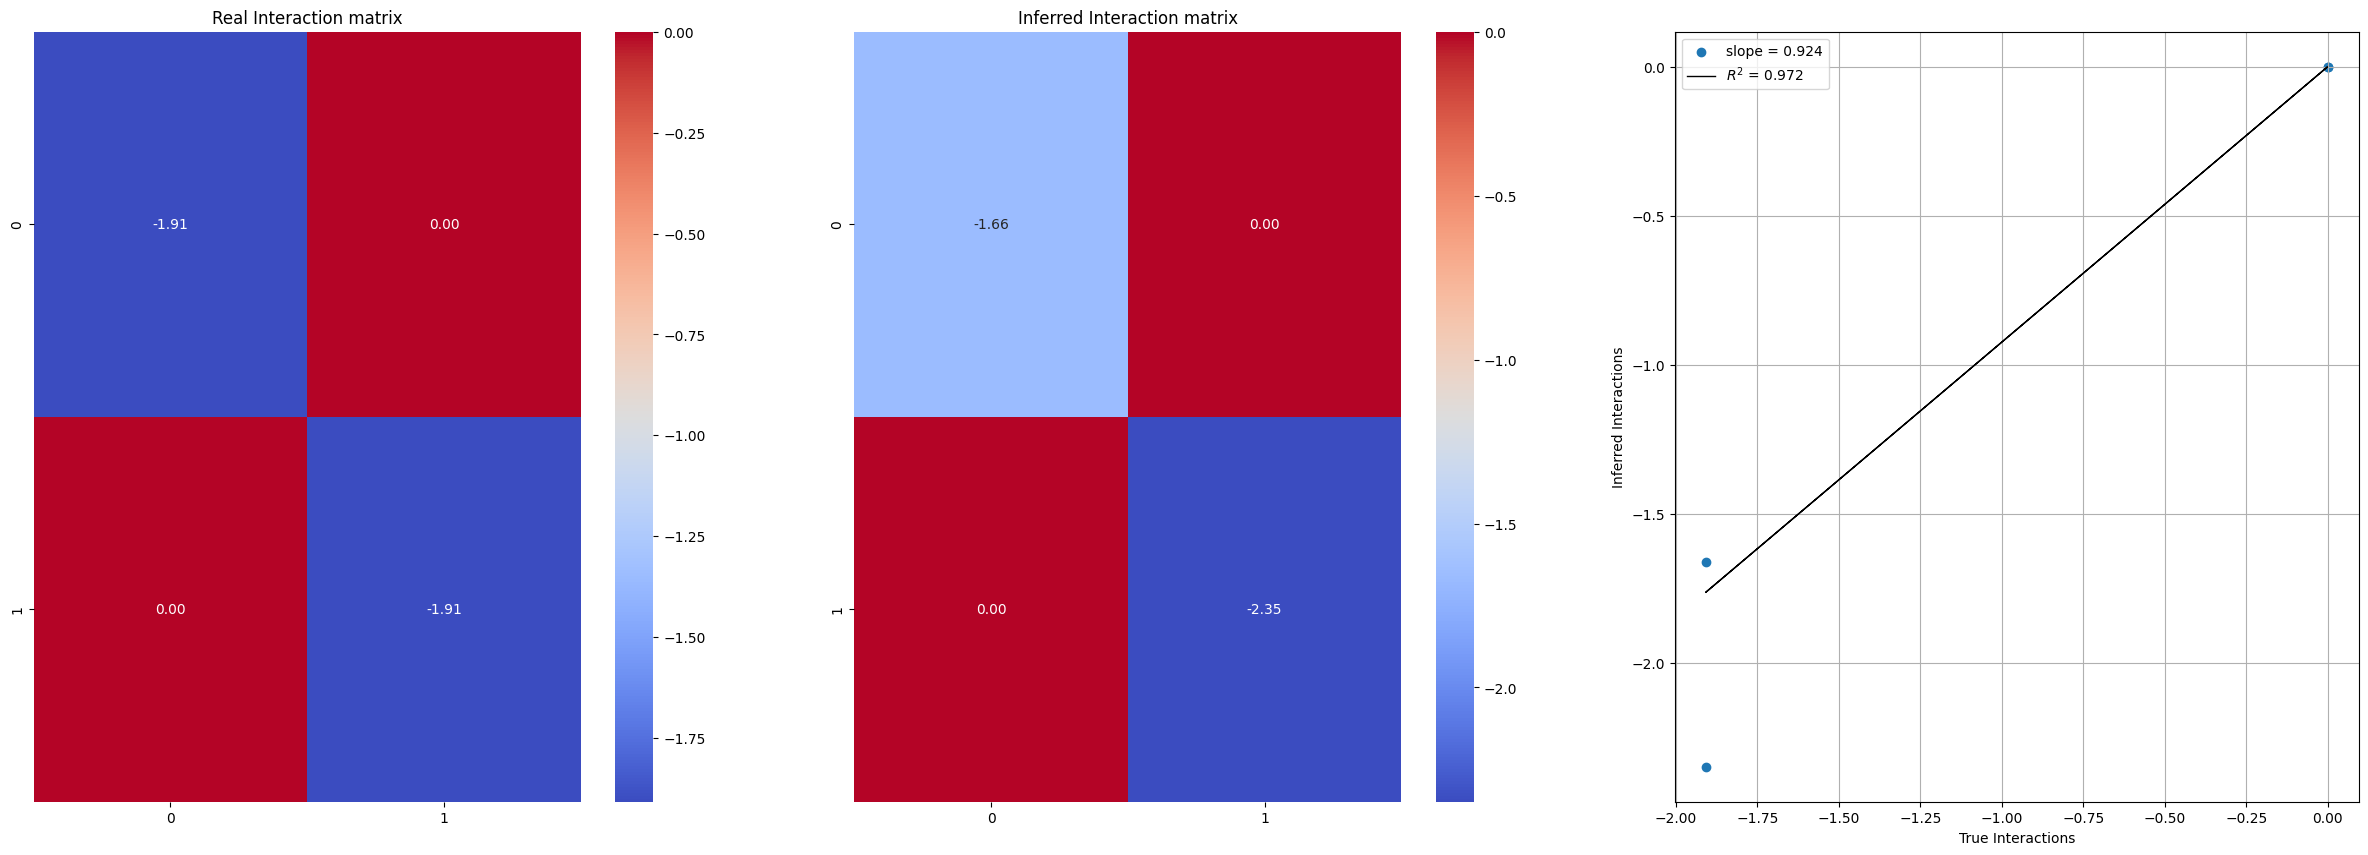

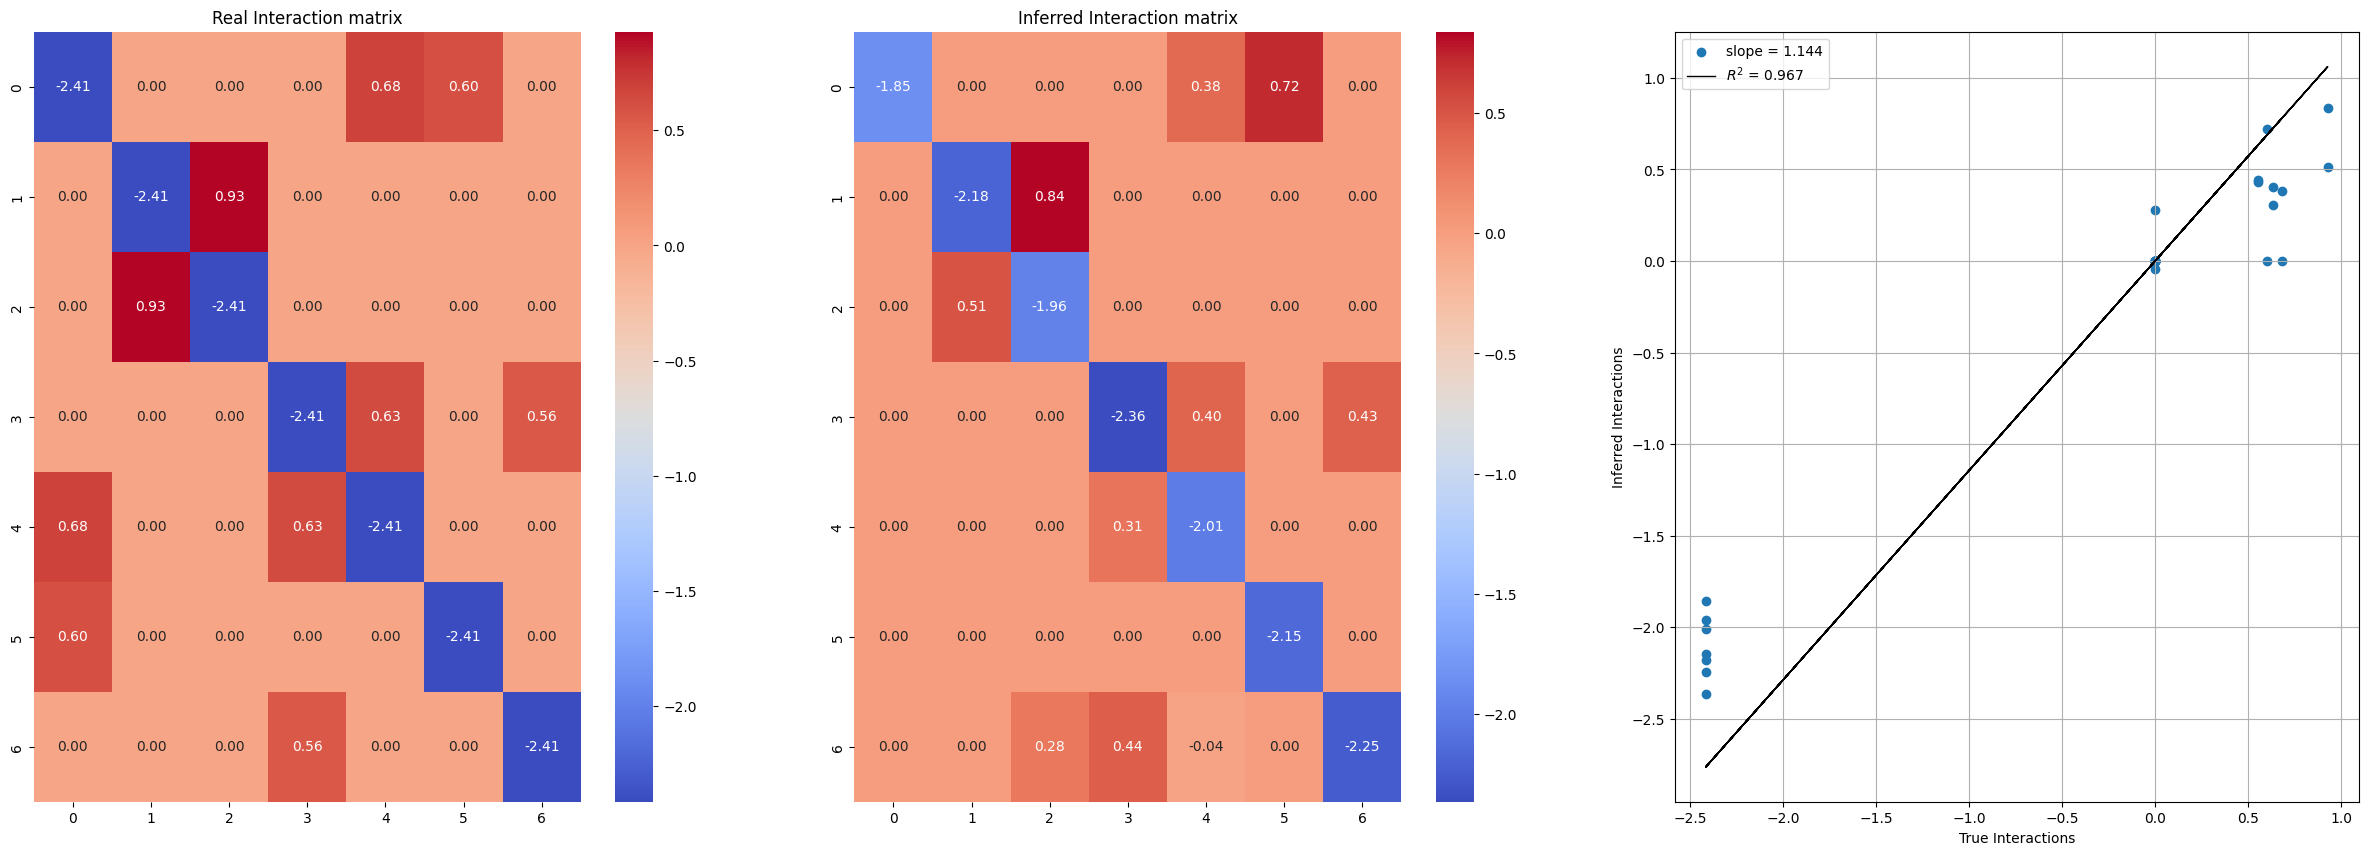

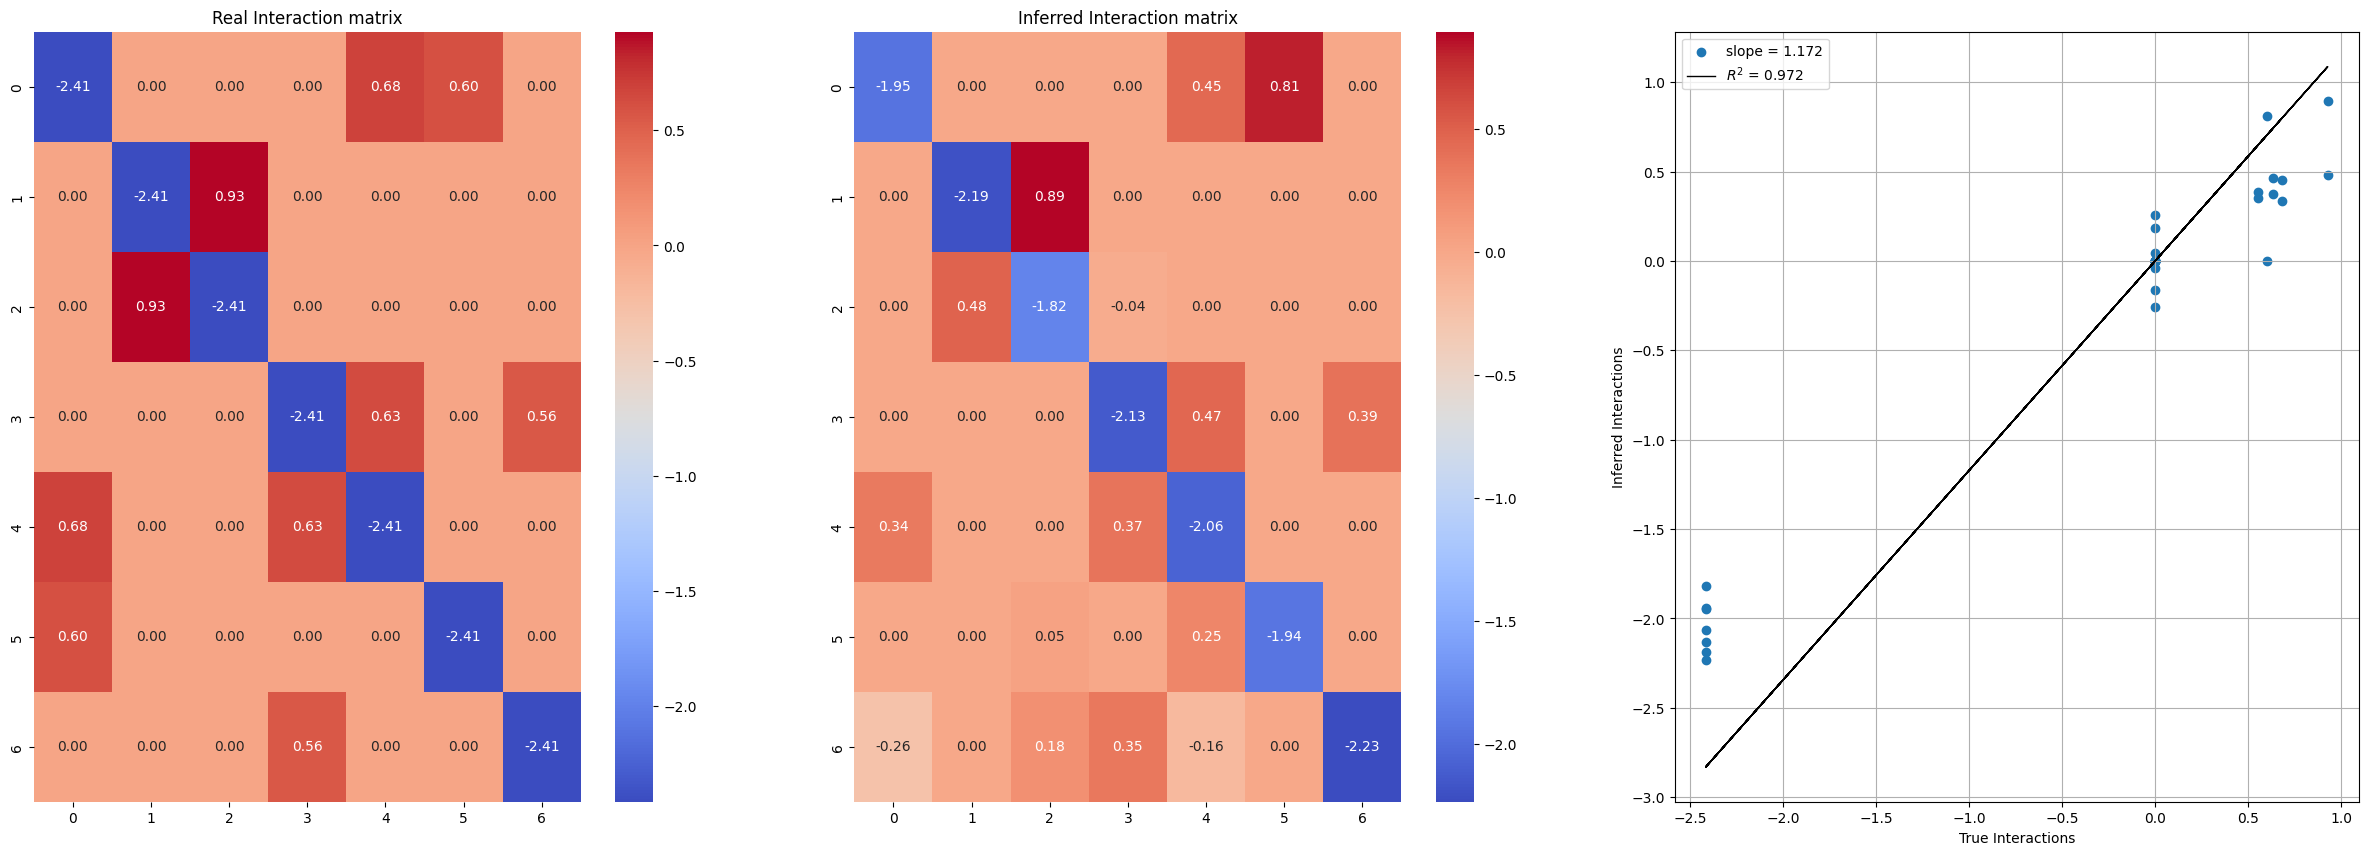

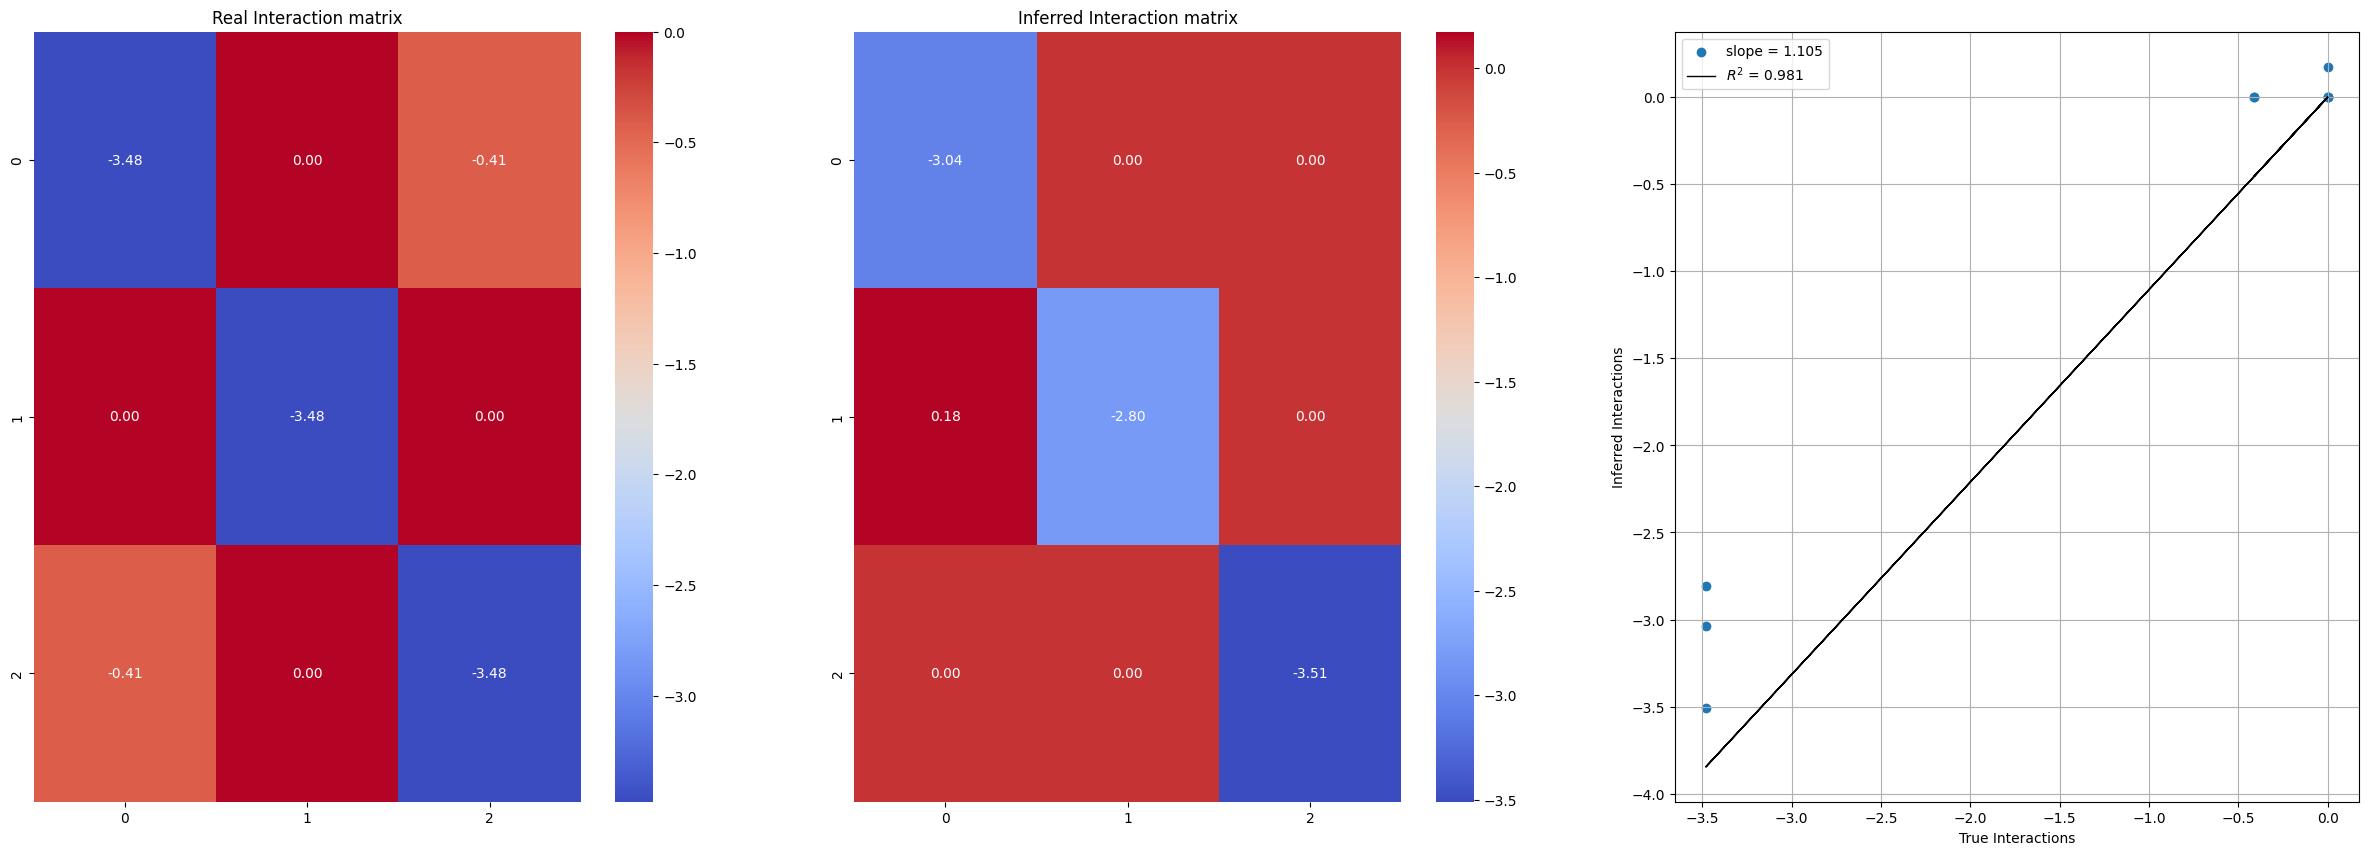

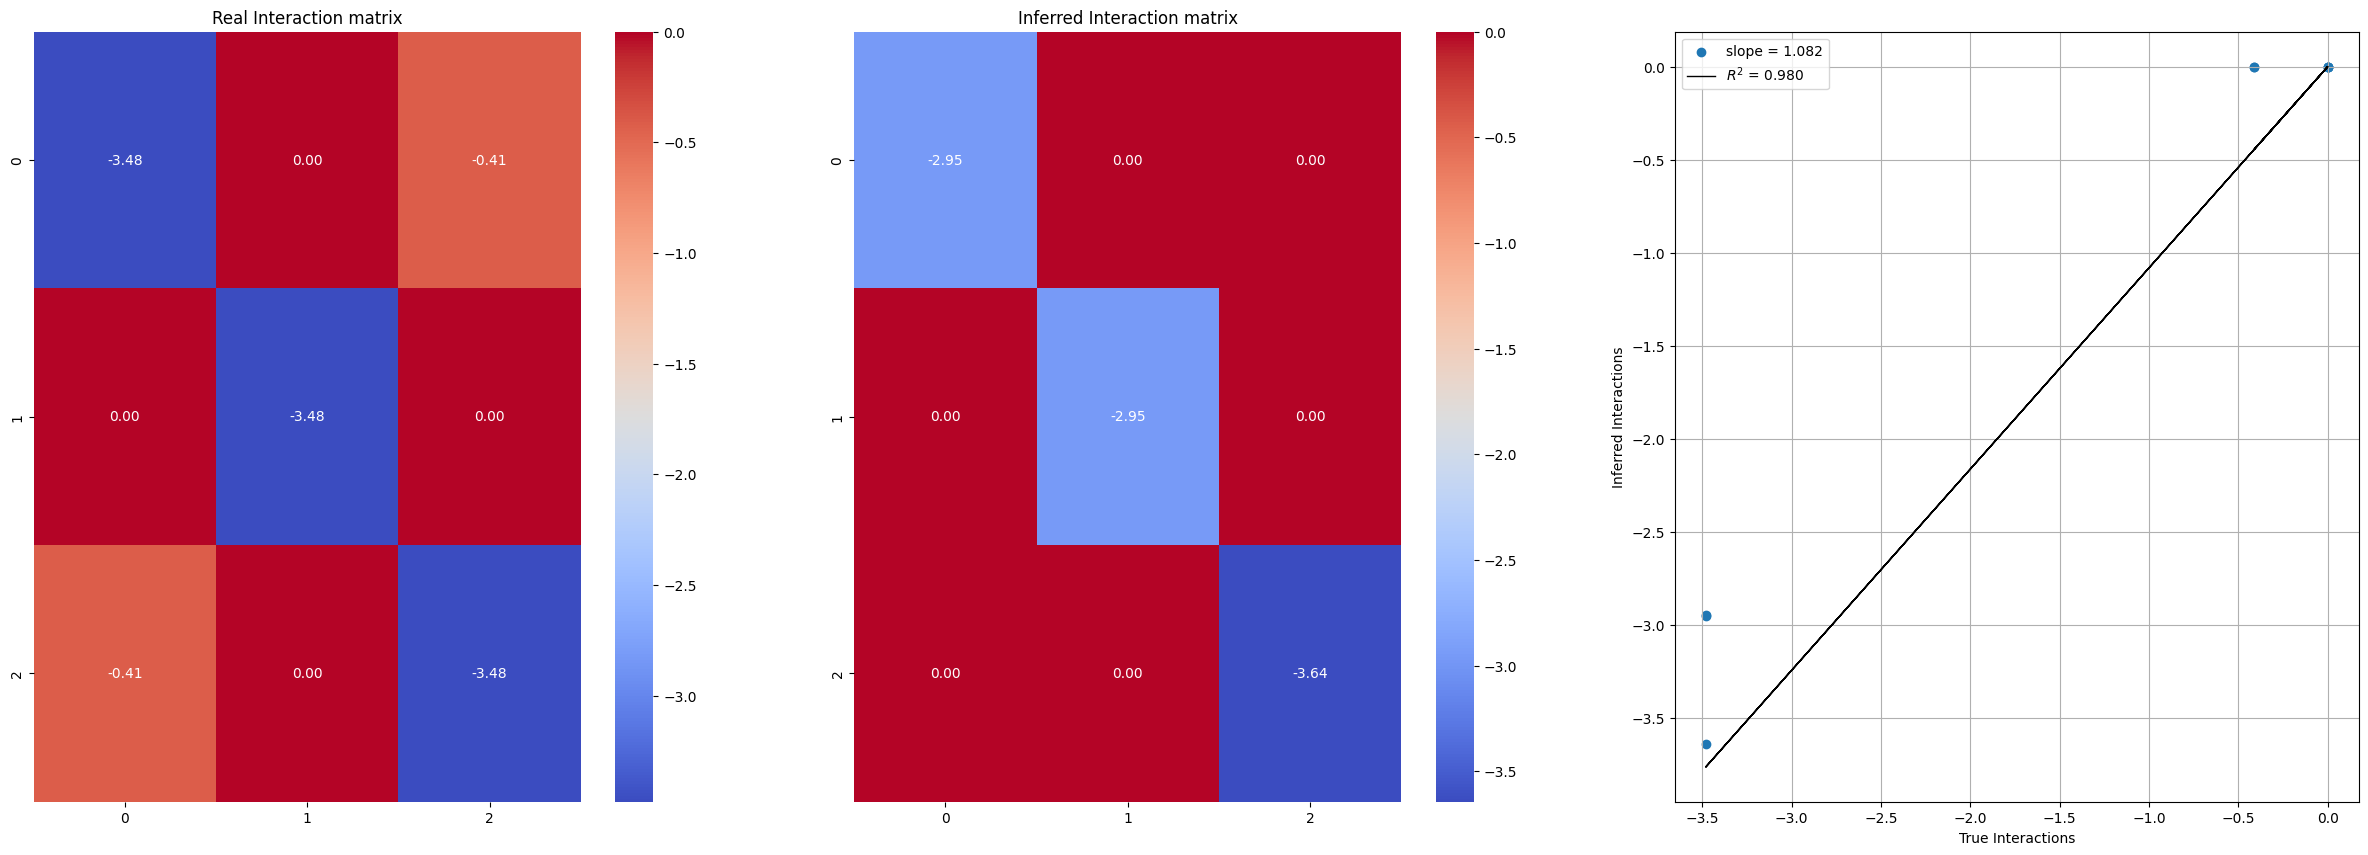

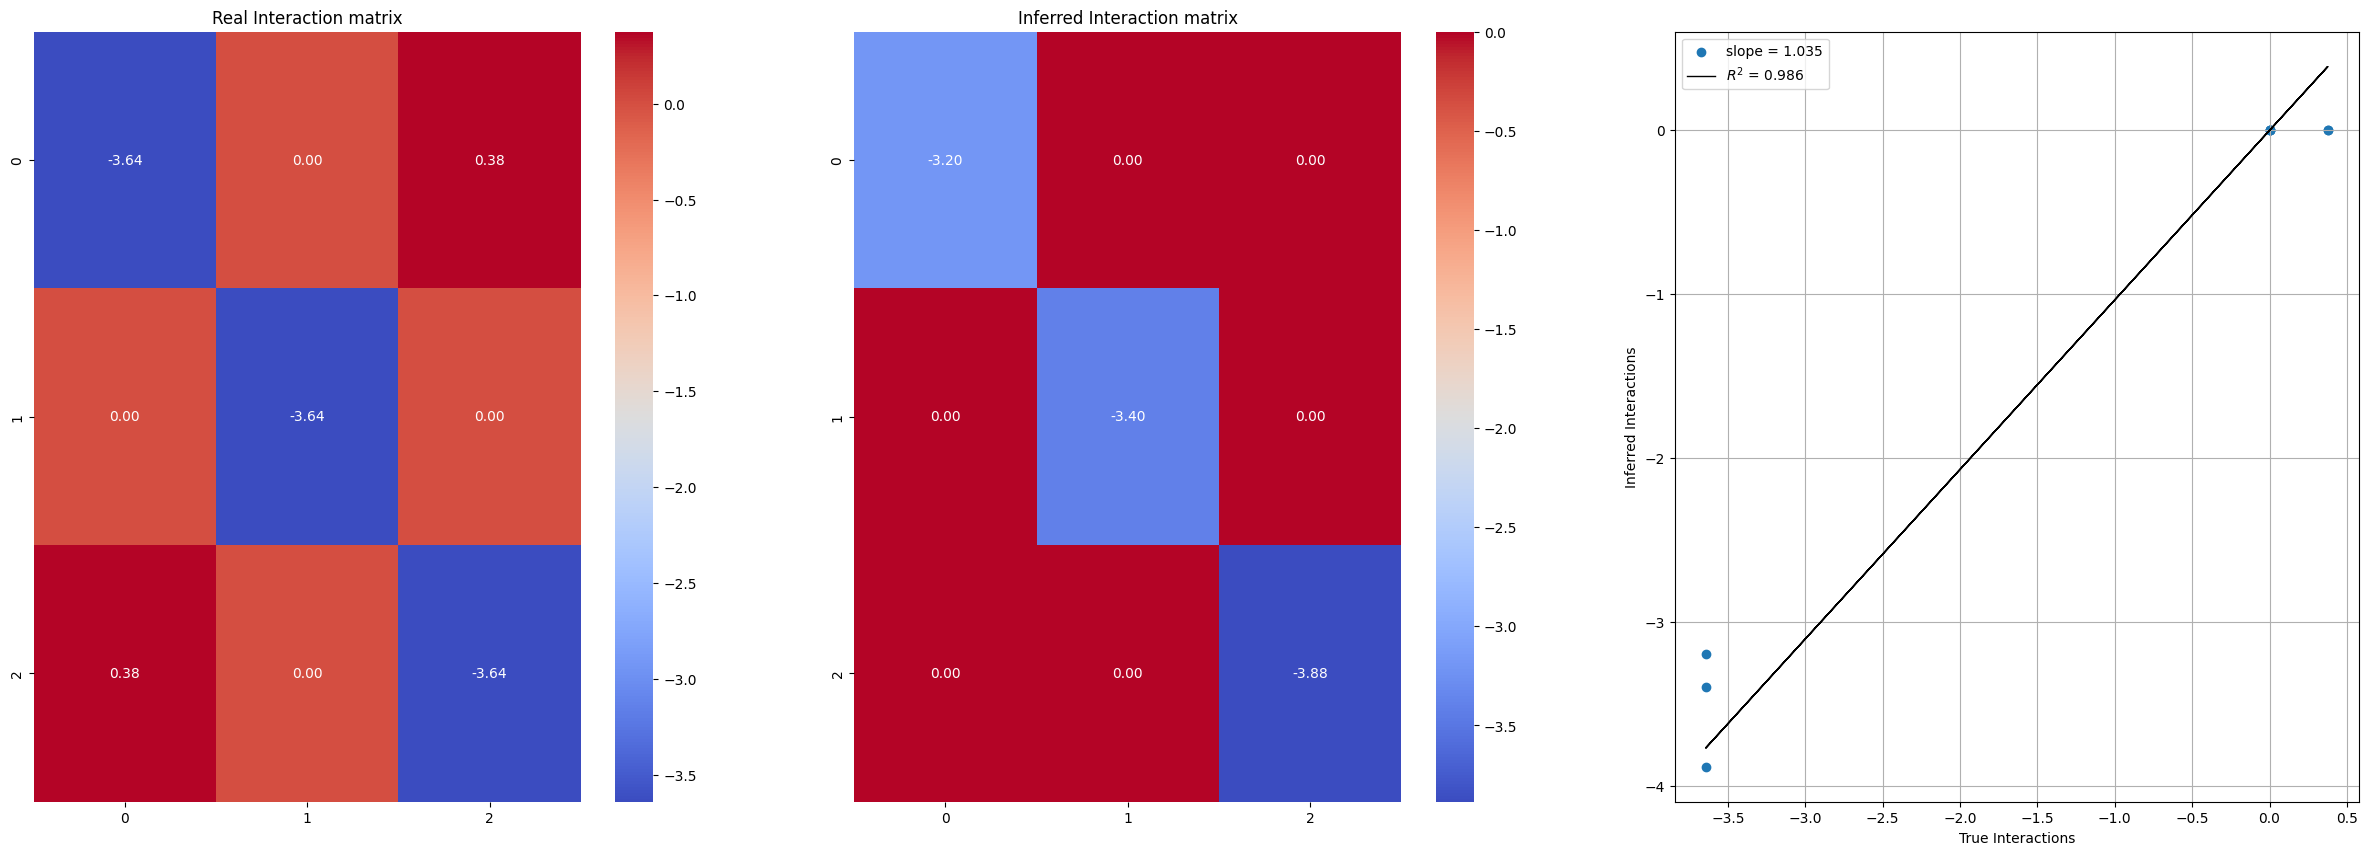

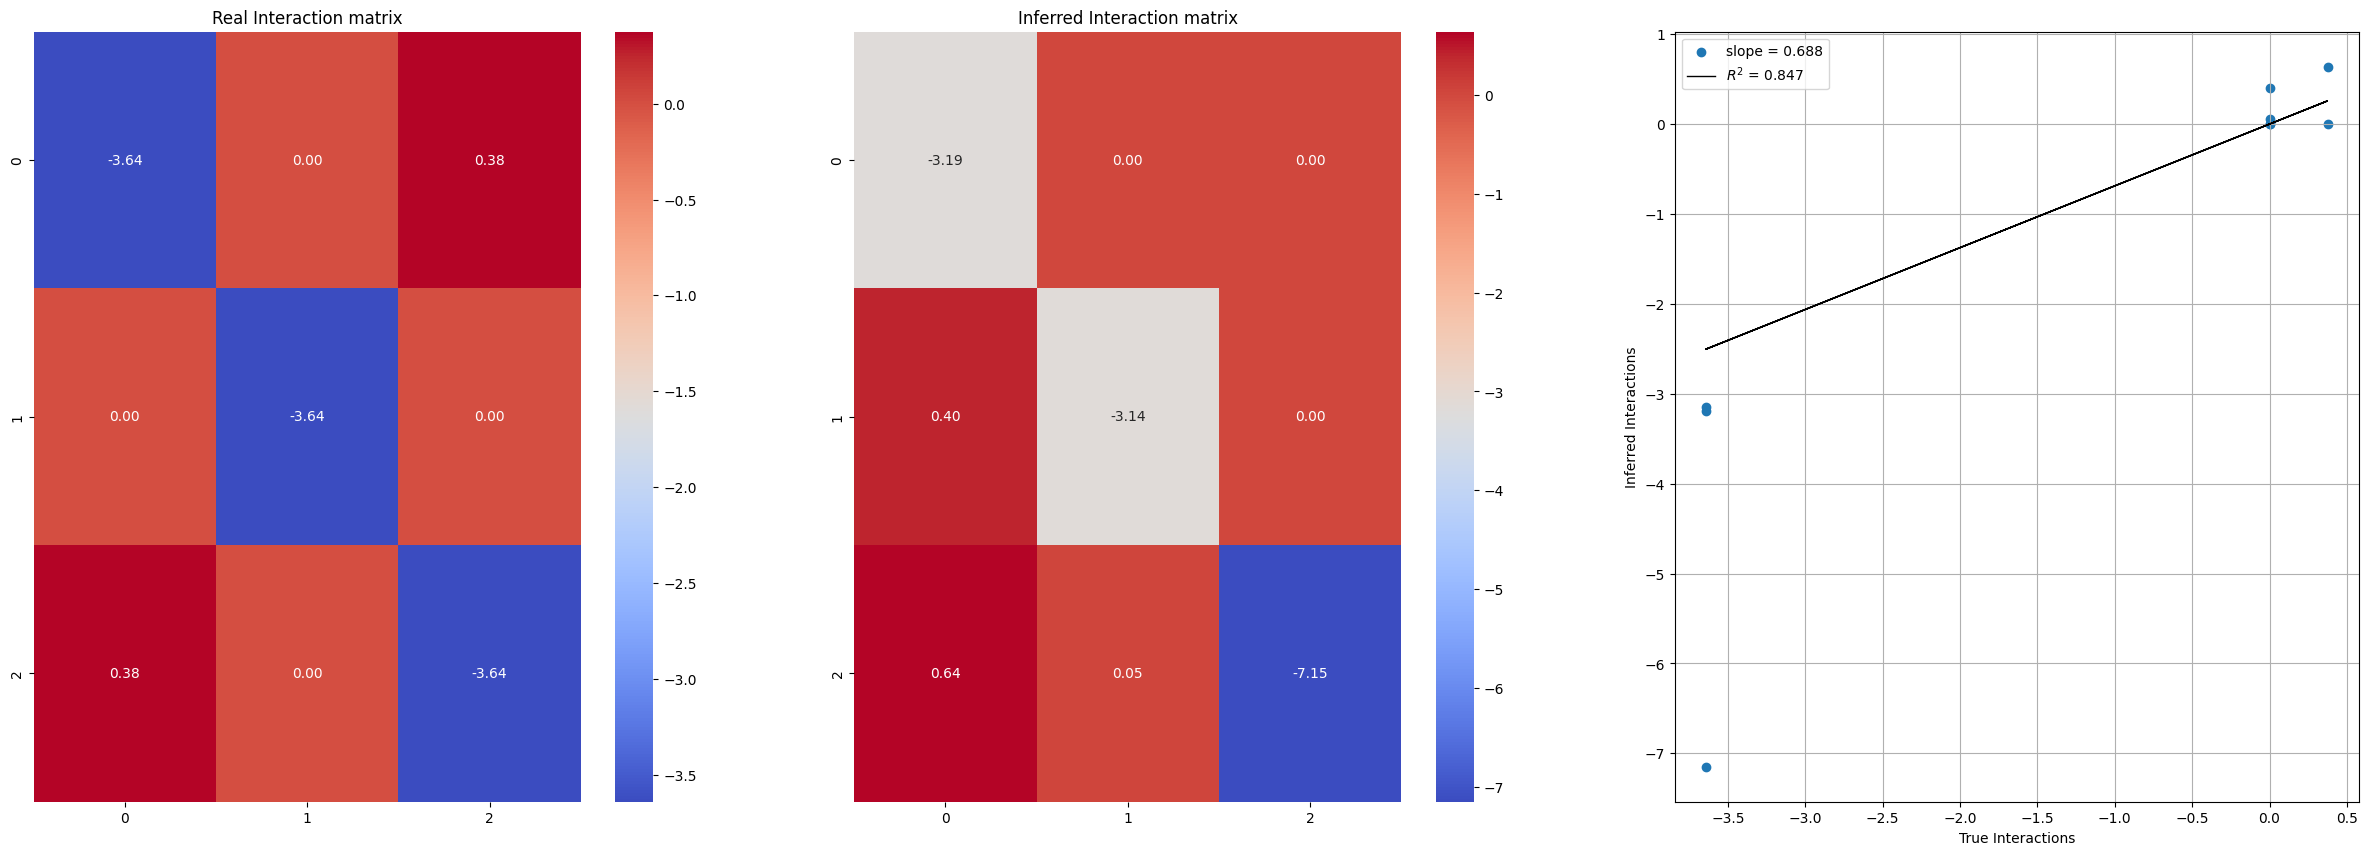

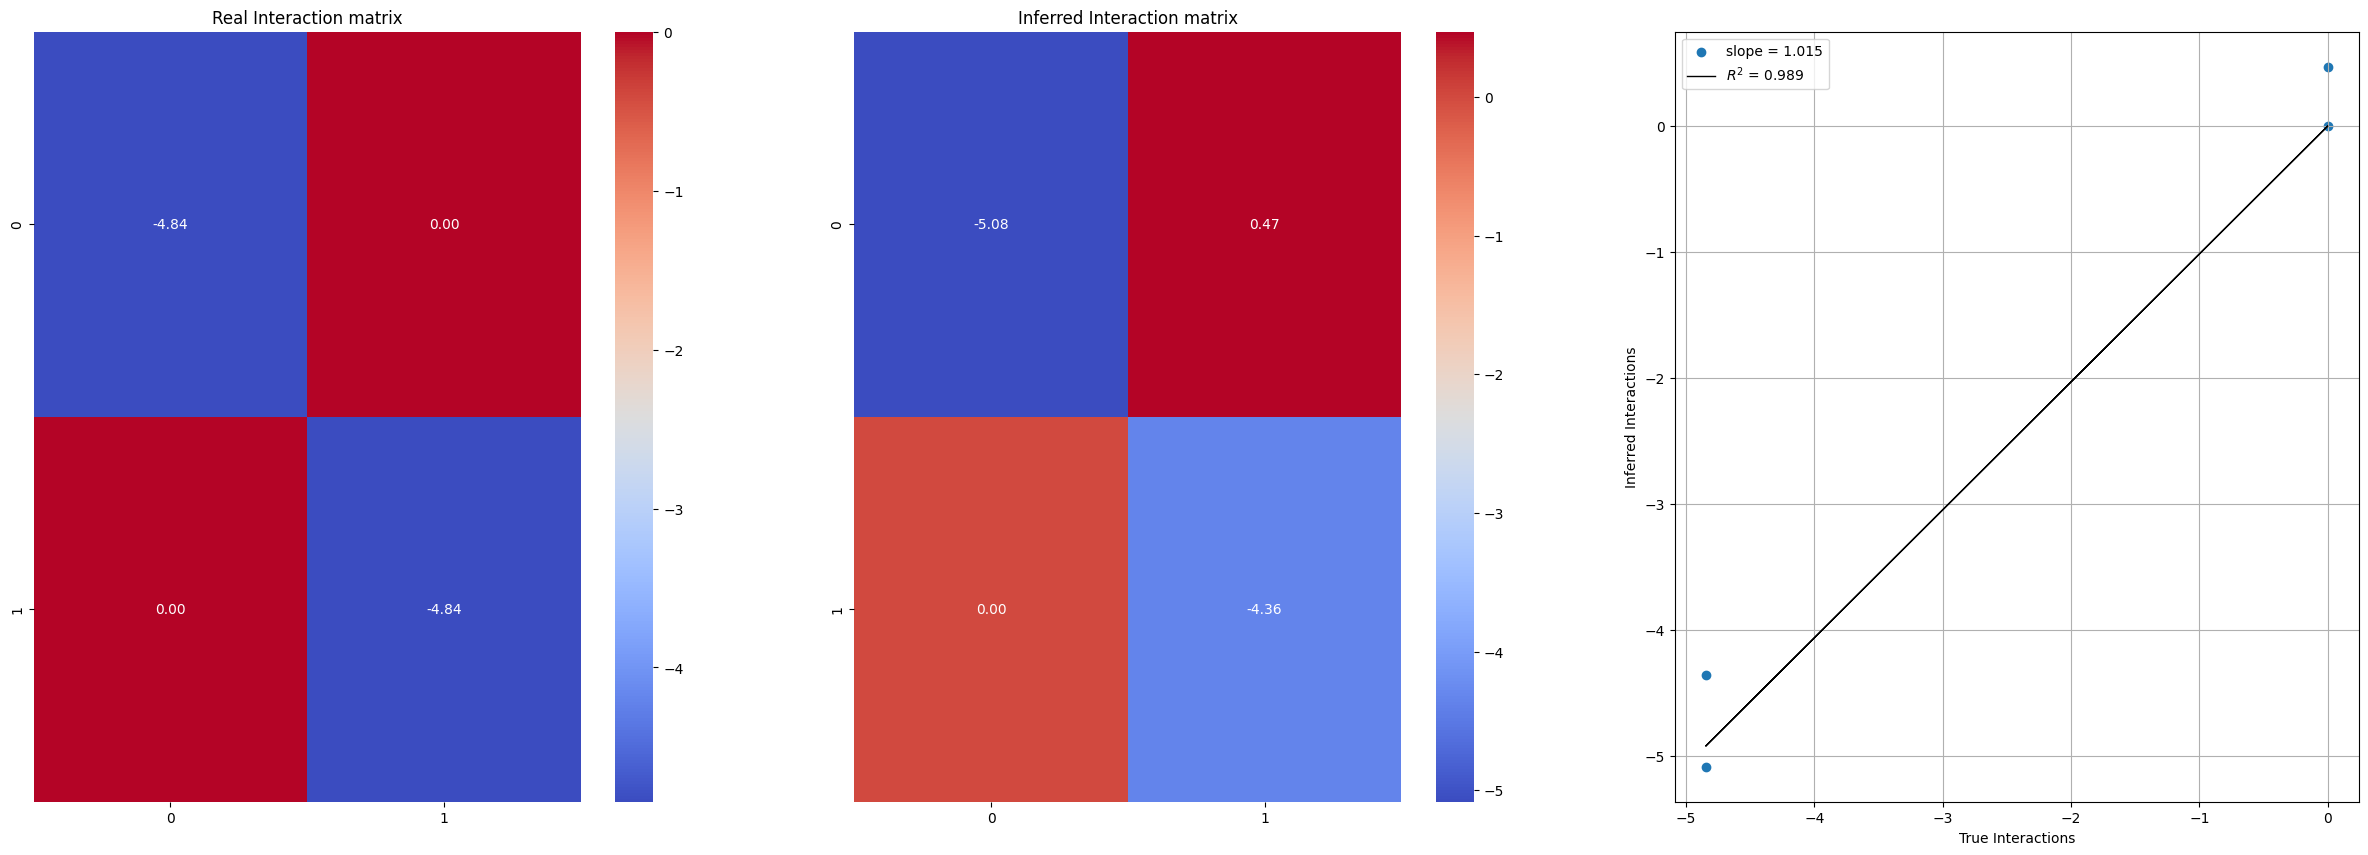

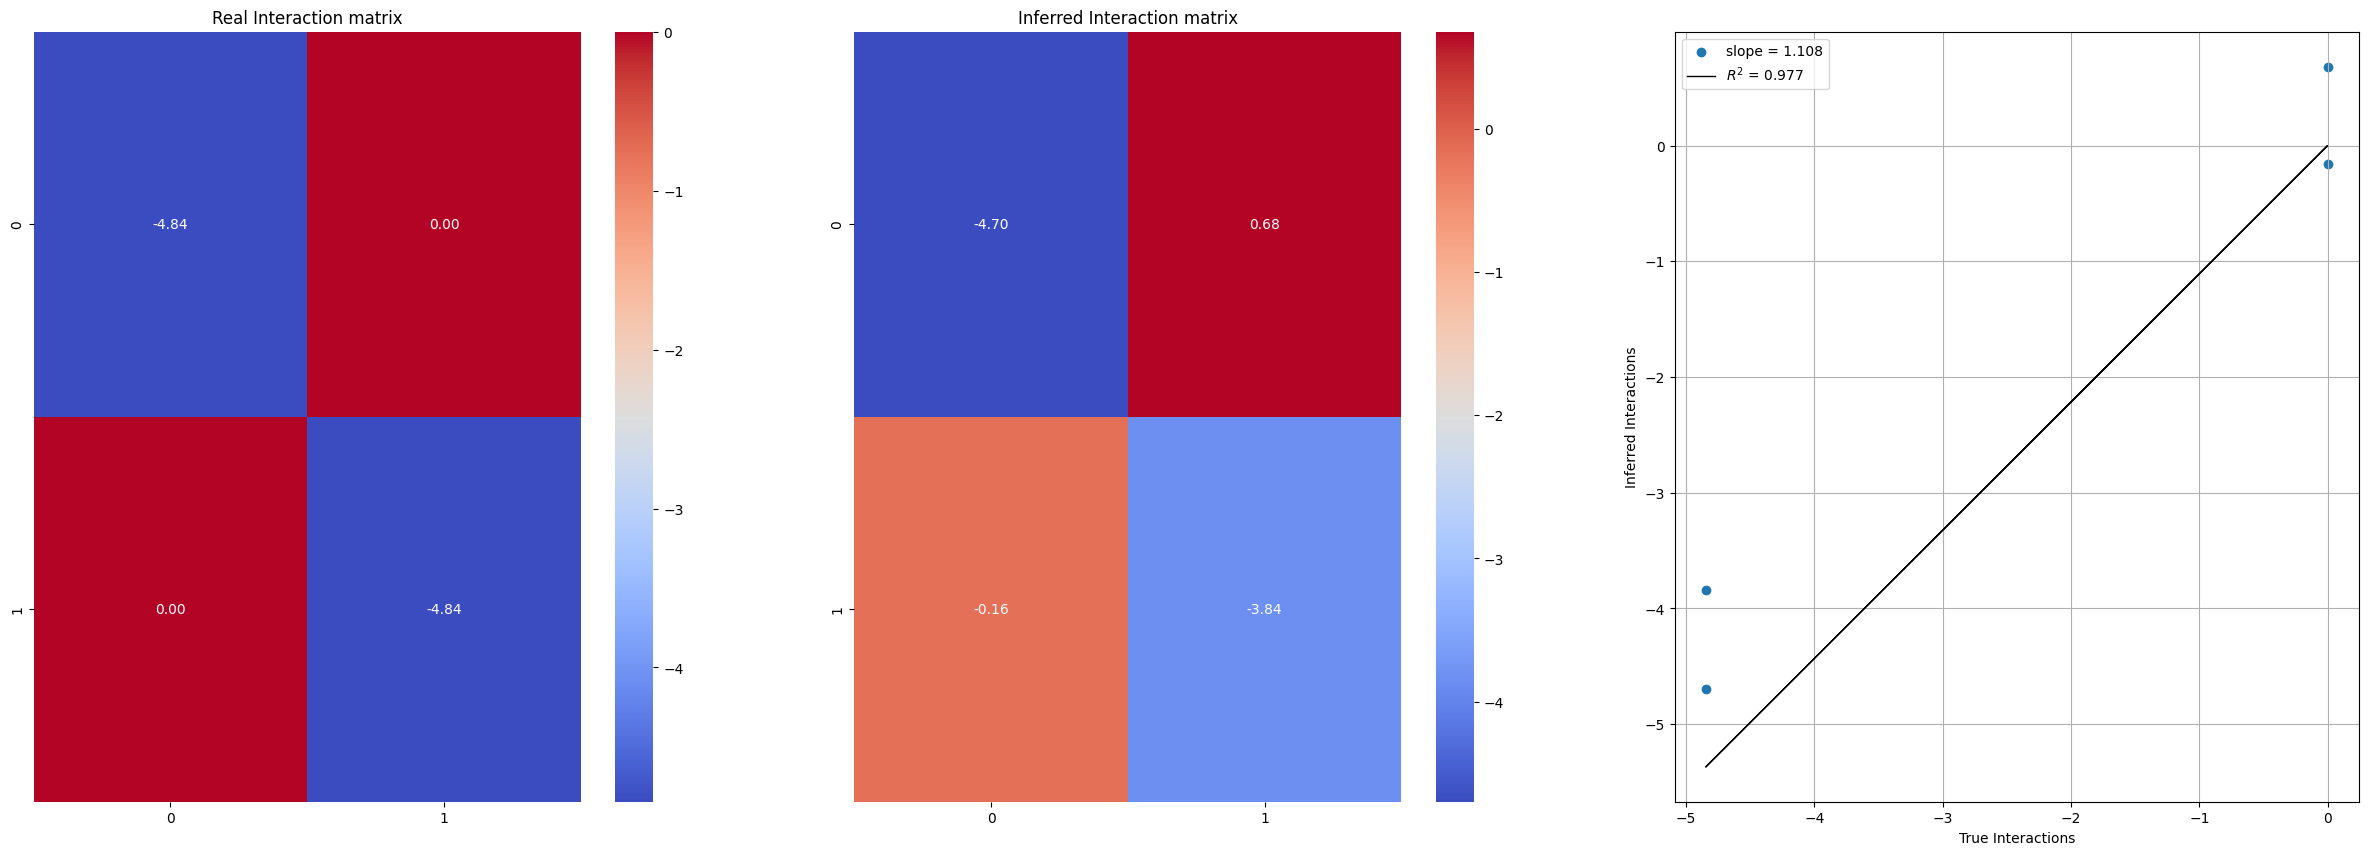

In [19]:
mc = Matrix_Comparison()
results_fisher = []
results_derivative = []

for instance in range(len(M_list)):
    #compare matrices
    M = M_list[instance]
    M_fisher = M_fisher_list[instance]
    M_derivative = M_derivative_list[instance]
    
    if(M.shape[0] > 1):
        r2, slope = mc.compare_matrices(M, M_fisher, normalize= False, plot= True, savefig=False)
        #time.sleep(1)
        r2, slope = mc.compare_matrices(M, M_derivative, normalize= False, plot= True, savefig=False) 

        results_fisher.append({"num_species": len(M), "sampling_interval": sampling, "noise": sigma, "sparsity": sparsity, "threshold": thr, "bagging": bag, "type_I": mc.compute_error_rates(M, M_fisher)[0], "type_II": mc.compute_error_rates(M, M_fisher)[1], "wrong_sign:": mc.compute_error_rates(M, M_fisher)[2], "RMSE": mc.root_mean_squared_error(M, M_fisher), "Frobenius": mc.relative_error_frobenius_norm(M, M_fisher), "Pearson": mc.pearson_correlation(M, M_fisher)})
        results_derivative.append({"num_species": len(M), "sampling_interval": sampling, "noise": sigma, "sparsity": sparsity, "threshold": thr, "bagging": bag, "type_I": mc.compute_error_rates(M, M_fisher)[0], "type_II": mc.compute_error_rates(M, M_fisher)[1], "wrong_sign:": mc.compute_error_rates(M, M_fisher)[2], "RMSE": mc.root_mean_squared_error(M, M_derivative), "Frobenius": mc.relative_error_frobenius_norm(M, M_derivative), "Pearson": mc.pearson_correlation(M, M_derivative)})

results_fisher_df = pd.DataFrame(results_fisher)
results_derivative_df = pd.DataFrame(results_derivative)


file_path = 'Regression/results_fisher.csv'
if not os.path.isfile(file_path):
    results_fisher_df.to_csv(file_path, mode='w', index=False, header=True)
else:
    results_fisher_df.to_csv(file_path, mode='a', index=False, header=False)


file_path = 'Regression/results_derivative.csv'
if not os.path.isfile(file_path):
    results_derivative_df.to_csv(file_path, mode='w', index=False, header=True)
else:
    results_derivative_df.to_csv(file_path, mode='a', index=False, header=False)

saved as Regression/matrix_comparison_2024-08-25_16-42-56.pdf


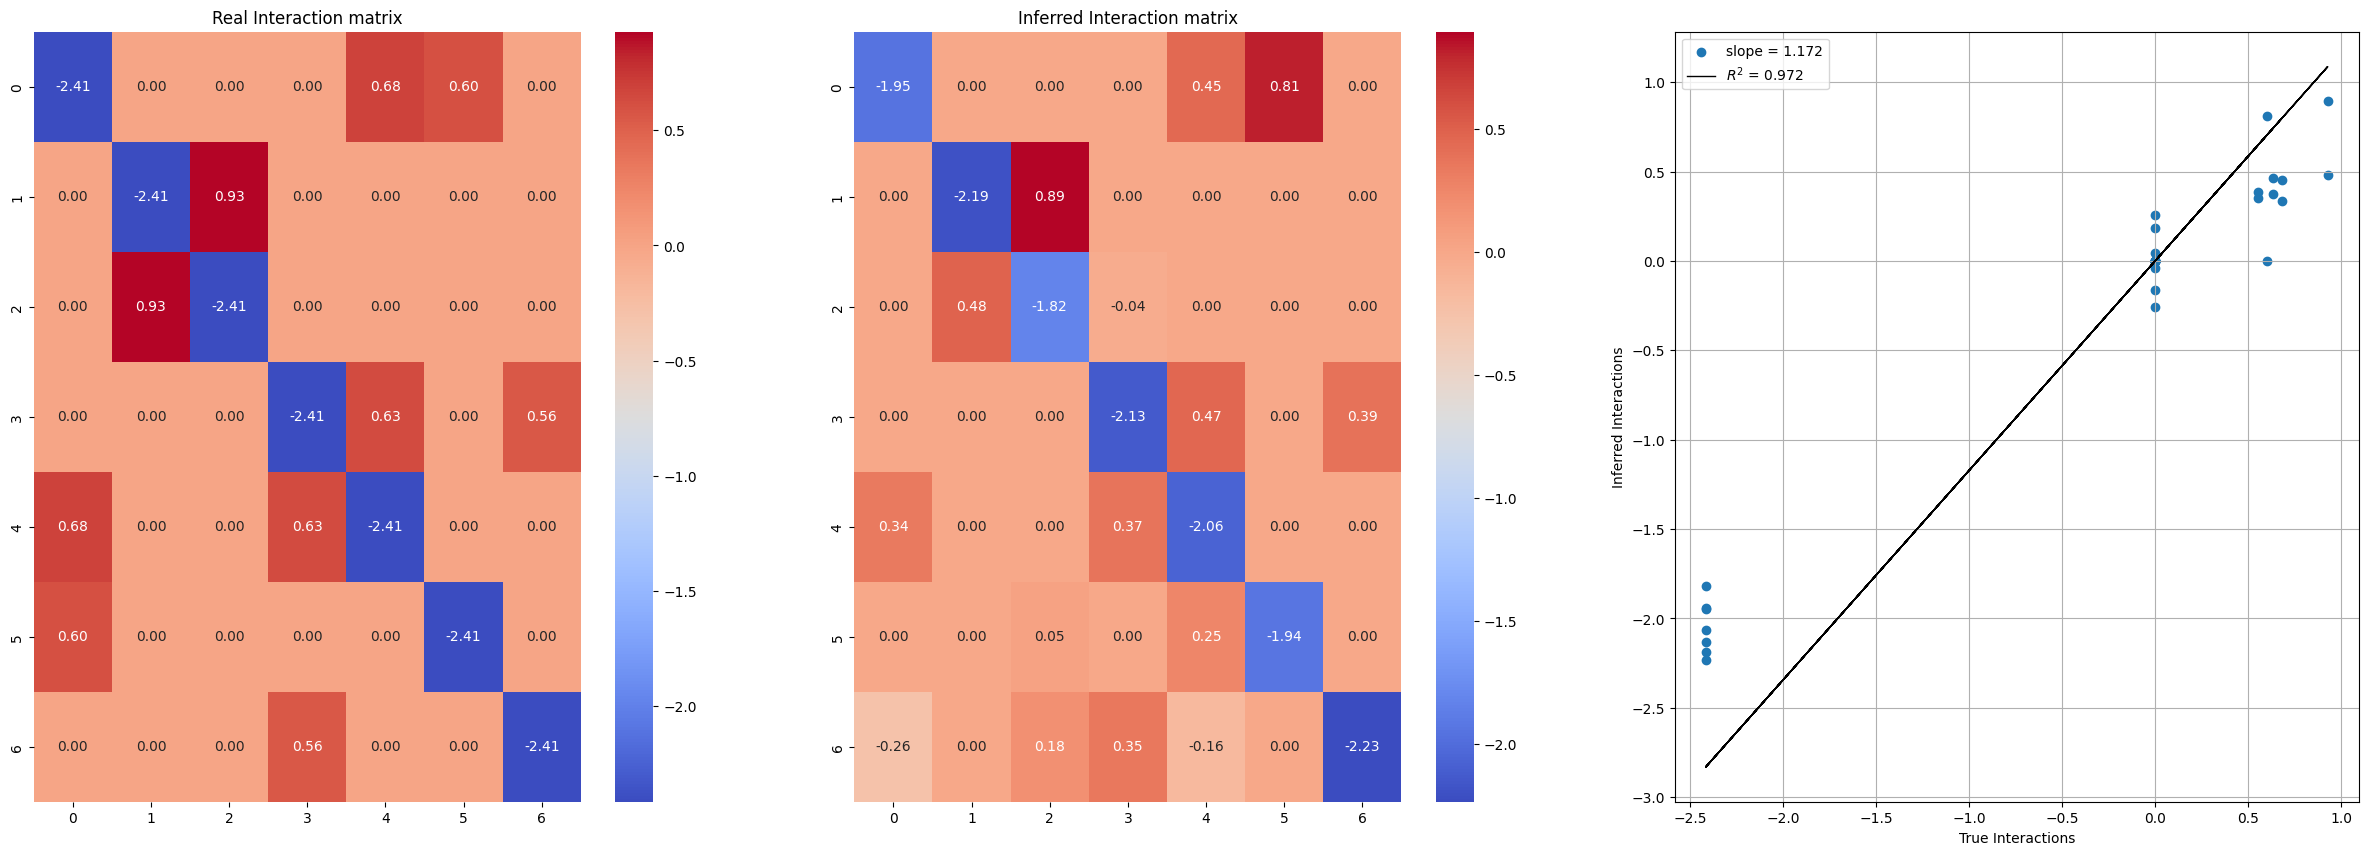

In [22]:
r2, slope = mc.compare_matrices(M_list[1], M_derivative_list[1], normalize= False, plot= True, savefig=True)